# Import librairies

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm 
import pmdarima as pm
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import dataset

In [2]:
link = '/Users/manu/Desktop/SUP/Projet 2/AI_model_urban_mobility/data/df_final_15min_NoNan_20250505.parquet'

In [3]:
df_trafic = pd.read_parquet(link)

In [5]:
df_trafic.head()

,nom_du_troncon,heure_arrondie,id_technique,id,debit,longueur,taux_occupation,code_couleur,etat_du_trafic,temps_de_parcours,...,etat_indice,geom_type,geom_coordinates,geo_point_2d_lon,geo_point_2d_lat,has_event_near_troncon,weekday,hour,minute,troncon_enc
0,3 Continents I,2025-02-16 20:15:00,5149-2025-02-16T20:15:00,5149,240.0,478.0,2.900000,3.0,Fluide,85.00,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,6,20,15,0
1,3 Continents I,2025-02-16 20:30:00,5149-2025-02-16T20:30:00,5149,180.0,478.0,1.600000,3.0,Fluide,81.00,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,6,20,30,0
2,3 Continents I,2025-02-16 20:45:00,5149-2025-02-16T20:45:00,5149,60.0,478.0,2.000000,3.0,Fluide,84.00,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,6,20,45,0
3,3 Continents I,2025-02-16 21:00:00,5149-2025-02-16T21:00:00,5149,240.0,478.0,2.900000,3.0,Fluide,83.00,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,6,21,0,0
4,3 Continents I,2025-02-16 21:15:00,nan-2025-02-16T21:15:00,nan,235.0,478.0,2.841667,3.0,Fluide,82.62,...,Consolidée,Feature,"[[[[-1.532422818, 47.295023199], [-1.527218409...",-1.548206,47.232044,False,6,21,15,0


In [4]:
df_trafic.columns

Index(['nom_du_troncon', 'heure_arrondie', 'id_technique', 'id', 'debit',
       'longueur', 'taux_occupation', 'code_couleur', 'etat_du_trafic',
       'temps_de_parcours', 'vitesse', 'geo_point_2d', 'geometrie',
       'shape_geo', 'horodatage', 'type_geo', 'coordinates_geo',
       'horodatage_date', 'jour', 'is_vacances', 'is_ferie',
       'rounded_horodatage', 'date', 'temperature_2m', 'visibility',
       'precipitation', 'wind_speed_10m', 'gml_id', 'date_ech', 'code_qual',
       'lib_qual', 'coul_qual', 'date_dif', 'source', 'type_zone', 'code_zone',
       'lib_zone', 'code_no2', 'code_so2', 'code_o3', 'code_pm10', 'code_pm25',
       'x_wgs84', 'y_wgs84', 'x_reg', 'y_reg', 'epsg_reg', 'etat_indice',
       'geom_type', 'geom_coordinates', 'geo_point_2d_lon', 'geo_point_2d_lat',
       'has_event_near_troncon', 'weekday', 'hour', 'minute', 'troncon_enc'],
      dtype='object')

In [15]:
colonnes_avec_null = df_trafic.columns[df_trafic.isna().sum() > 0]

# TEST 1 - Prophet

## Configuration

In [ ]:
# Configuration
troncon_id_a_traiter = 0
target_variable = 'taux_occupation'
colonne_horodatage = 'heure_arrondie'
colonne_troncon = 'troncon_enc'

# Régresseurs choisis
weather_regressors = ['temperature_2m', 'visibility', 'precipitation', 'wind_speed_10m']
event_regressors = ['is_vacances', 'is_ferie', 'has_event_near_troncon', 'weekday']
all_regressors = weather_regressors + event_regressors

# Découpage train
date_debut_train_str = '2025-02-16'
date_fin_train_str = '2025-03-07'

# Découpage test
date_debut_test_str = '2025-03-08'
date_fin_test_str = '2025-03-14'

In [5]:
# S'assurer que la colonne d'horodatage est au format datetime
try:
    df_trafic[colonne_horodatage] = pd.to_datetime(df_trafic[colonne_horodatage])
except Exception as e:
    print(f"Erreur lors de la conversion de la colonne '{colonne_horodatage}' en datetime: {e}. Arrêt.")
    exit()

## Train/test

In [6]:
date_debut_train = pd.to_datetime(f'{date_debut_train_str} 00:00:00')
date_fin_train = pd.to_datetime(f'{date_fin_train_str} 23:59:59')
date_debut_test = pd.to_datetime(f'{date_debut_test_str} 00:00:00')
date_fin_test = pd.to_datetime(f'{date_fin_test_str} 23:59:59')

train_data_full = df_trafic[ 
    (df_trafic[colonne_horodatage] >= date_debut_train) &
    (df_trafic[colonne_horodatage] <= date_fin_train)
].copy()

test_data_full = df_trafic[ 
    (df_trafic[colonne_horodatage] >= date_debut_test) &
    (df_trafic[colonne_horodatage] <= date_fin_test)
].copy()

print(f"\n--- Jeu d'entraînement complet ---")
print(f"Nombre de lignes : {len(train_data_full)}, Période : {train_data_full[colonne_horodatage].min()} à {train_data_full[colonne_horodatage].max()}")
print(f"--- Jeu de test complet ---")
print(f"Nombre de lignes : {len(test_data_full)}, Période : {test_data_full[colonne_horodatage].min()} à {test_data_full[colonne_horodatage].max()}")

if train_data_full.empty or test_data_full.empty:
    print("ATTENTION: L'un des jeux de données (train ou test) est vide après la séparation. Vérifiez vos dates et données sources. Arrêt.")
    exit()


--- Jeu d'entraînement complet ---
Nombre de lignes : 1377411, Période : 2025-02-16 20:15:00 à 2025-03-07 23:45:00
--- Jeu de test complet ---
Nombre de lignes : 503328, Période : 2025-03-08 00:00:00 à 2025-03-14 23:45:00


## Filtrage pour un tronçon

In [7]:
train_df_troncon = train_data_full[train_data_full[colonne_troncon] == troncon_id_a_traiter].copy()
test_df_troncon = test_data_full[test_data_full[colonne_troncon] == troncon_id_a_traiter].copy()

if train_df_troncon.empty or test_df_troncon.empty:
    print(f"ATTENTION: L'un des jeux de données (train ou test) pour le tronçon {troncon_id_a_traiter} est vide. Arrêt.")
    exit()

print(f"\nDonnées d'entraînement pour tronçon {troncon_id_a_traiter}: {len(train_df_troncon)} lignes.")
print(f"Données de test pour tronçon {troncon_id_a_traiter}: {len(test_df_troncon)} lignes.")


Données d'entraînement pour tronçon 0: 1839 lignes.
Données de test pour tronçon 0: 672 lignes.


## Entraînement

In [17]:
df_prophet_train = pd.DataFrame()
df_prophet_train['ds'] = train_df_troncon[colonne_horodatage]
df_prophet_train['y'] = train_df_troncon[target_variable]

In [18]:
for regressor in all_regressors:
    if regressor in train_df_troncon.columns:
        df_prophet_train[regressor] = train_df_troncon[regressor].astype(float)
        if df_prophet_train[regressor].isnull().any():
            median_val_train_reg = df_prophet_train[regressor].median() 
            df_prophet_train[regressor] = df_prophet_train[regressor].fillna(median_val_train_reg)
            print(f"Valeurs NaN dans '{regressor}' (train) remplacées par médiane: {median_val_train_reg}")
    else:
        print(f"ATTENTION: Régresseur '{regressor}' non trouvé dans train_df_troncon.")
        
if df_prophet_train.shape[0] < 2:
    print(f"Pas assez de données ({df_prophet_train.shape[0]} lignes) pour entraîner Prophet. Arrêt.")
    exit()

In [19]:
print(f"\nInitialisation et entraînement du modèle Prophet pour {target_variable} sur tronçon {troncon_id_a_traiter}...")
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)

for regressor in all_regressors:
    if regressor in df_prophet_train.columns:
        model.add_regressor(regressor)

model.fit(df_prophet_train)
print("Entraînement du modèle terminé.")


Initialisation et entraînement du modèle Prophet pour taux_occupation sur tronçon 0...


17:10:16 - cmdstanpy - INFO - Chain [1] start processing
17:10:18 - cmdstanpy - INFO - Chain [1] done processing


Entraînement du modèle terminé.


## Prédictions

In [20]:
future_for_test = pd.DataFrame()
future_for_test['ds'] = test_df_troncon[colonne_horodatage]

for regressor in all_regressors:
    if regressor in test_df_troncon.columns:
        future_for_test[regressor] = test_df_troncon[regressor].astype(float)
        if future_for_test[regressor].isnull().any():
            if regressor in df_prophet_train.columns:
                 median_val_train_reg_for_test = df_prophet_train[regressor].median()
                 future_for_test[regressor] = future_for_test[regressor].fillna(median_val_train_reg_for_test)
                 print(f"Valeurs NaN dans '{regressor}' (test) remplacées par médiane d'entraînement: {median_val_train_reg_for_test}")
            else:
                 future_for_test[regressor] = future_for_test[regressor].fillna(0)
                 print(f"Valeurs NaN dans '{regressor}' (test) remplacées par 0 (régresseur non trouvé dans train).")
    else:
        print(f"ATTENTION: Régresseur '{regressor}' non trouvé dans test_df_troncon. Remplissage par 0.")
        future_for_test[regressor] = 0.0

print("\nDataFrame 'future_for_test' préparé (premières lignes) :")
print(future_for_test.head())


# --- 7. Faire les Prédictions sur l'Ensemble de Test ---
print("\nRéalisation des prédictions sur l'ensemble de test...")
forecast_test = model.predict(future_for_test)
print("Prédictions sur l'ensemble de test terminées.")


DataFrame 'future_for_test' préparé (premières lignes) :
                      ds  temperature_2m  visibility  precipitation  \
1839 2025-03-08 00:00:00       13.480500     24140.0            0.0   
1840 2025-03-08 00:15:00       13.480500     24140.0            0.0   
1841 2025-03-08 00:30:00       13.480500     24140.0            0.0   
1842 2025-03-08 00:45:00       12.830501     24140.0            0.0   
1843 2025-03-08 01:00:00       12.830501     24140.0            0.0   

      wind_speed_10m  is_vacances  is_ferie  has_event_near_troncon  
1839       16.135872          0.0       0.0                     0.0  
1840       16.135872          0.0       0.0                     0.0  
1841       16.135872          0.0       0.0                     0.0  
1842       14.578890          0.0       0.0                     0.0  
1843       14.578890          0.0       0.0                     0.0  

Réalisation des prédictions sur l'ensemble de test...
Prédictions sur l'ensemble de test termi

## Evaluation

In [21]:
results_df = pd.merge(test_df_troncon[[colonne_horodatage, target_variable]],
                      forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
                      left_on=colonne_horodatage, right_on='ds', how='inner')
results_df = results_df.rename(columns={target_variable: 'y_true', 'yhat': 'y_pred'})

if not results_df.empty:
    mae = mean_absolute_error(results_df['y_true'], results_df['y_pred'])
    print(f"\n--- Évaluation sur l'Ensemble de Test ---")
    print(f"Erreur Absolue Moyenne (MAE) pour {target_variable}: {mae:.2f}")

    print("\nAperçu des résultats (réel vs prédit) :")
    print(results_df[['ds', 'y_true', 'y_pred', 'yhat_lower', 'yhat_upper']].head())
else:
    print("Aucune donnée pour l'évaluation après fusion. Vérifiez les timestamps.")


--- Évaluation sur l'Ensemble de Test ---
Erreur Absolue Moyenne (MAE) pour taux_occupation: 2.22

Aperçu des résultats (réel vs prédit) :
                   ds    y_true    y_pred  yhat_lower  yhat_upper
0 2025-03-08 00:00:00  3.300000  3.405091   -1.135685    7.782133
1 2025-03-08 00:15:00  1.200000  3.254060   -1.700203    7.889634
2 2025-03-08 00:30:00  0.800000  3.048467   -1.447672    7.626713
3 2025-03-08 00:45:00  2.500000  2.794647   -1.694228    7.313070
4 2025-03-08 01:00:00  2.311111  2.511385   -1.837930    6.748254


## Visualisation

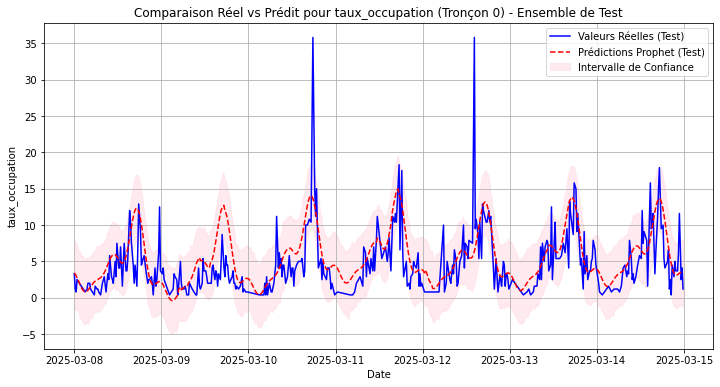


Affichage des composantes du modèle (basées sur la période de test)...


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing pytho

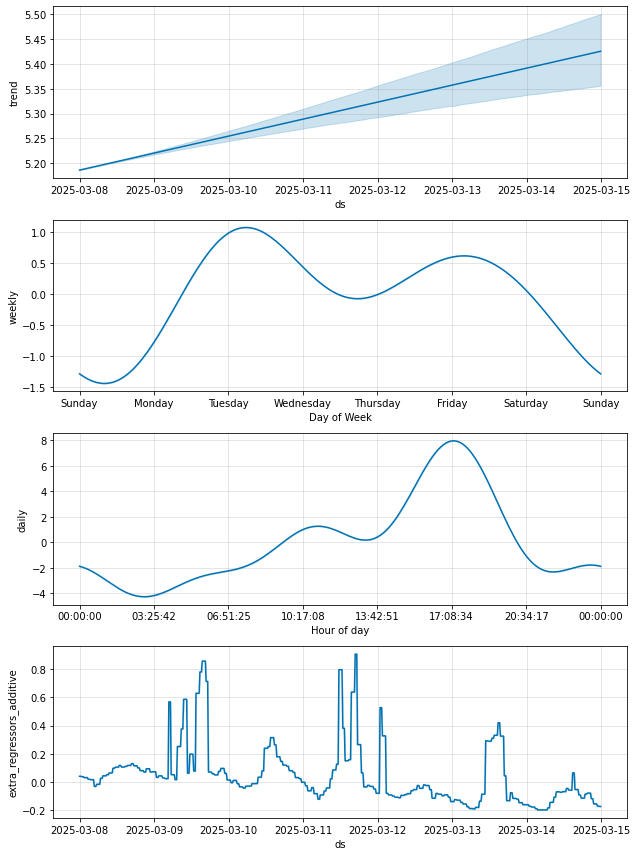

In [22]:
if not results_df.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['ds'], results_df['y_true'], label='Valeurs Réelles (Test)', color='blue')
    plt.plot(results_df['ds'], results_df['y_pred'], label='Prédictions Prophet (Test)', color='red', linestyle='--')
    plt.fill_between(results_df['ds'], results_df['yhat_lower'], results_df['yhat_upper'], color='pink', alpha=0.3, label='Intervalle de Confiance')
    plt.title(f"Comparaison Réel vs Prédit pour {target_variable} (Tronçon {troncon_id_a_traiter}) - Ensemble de Test")
    plt.xlabel("Date")
    plt.ylabel(target_variable)
    plt.legend()
    plt.grid(True)
    plt.show()

if 'ds' in forecast_test and not forecast_test.empty:
    try:
        print("\nAffichage des composantes du modèle (basées sur la période de test)...")
        fig_components = model.plot_components(forecast_test)
        plt.show()
    except Exception as e:
        print(f"Erreur lors du tracé des composantes : {e}")
else:
    print("Impossible de tracer les composantes, forecast_test est vide ou ne contient pas 'ds'.")

# TEST 2 - SARIMAX

In [11]:
# --- Paramètres ---
top_k = 5  # Nombre de régressors à conserver

# --- 1. Préparation des Données ---
train_df_troncon = train_df_troncon.set_index(colonne_horodatage)
test_df_troncon = test_df_troncon.set_index(colonne_horodatage)

train_target = train_df_troncon[target_variable]
train_regressors_all = train_df_troncon[all_regressors].astype(float)

test_target = test_df_troncon[target_variable]
test_regressors_all = test_df_troncon[all_regressors].astype(float)

/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[96] intercept   : AIC=9232.593, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[96] intercept   : AIC=11105.998, Time=0.03 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[96] intercept   : AIC=9283.550, Time=24.83 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[96] intercept   : AIC=9894.237, Time=21.59 sec
 ARIMA(0,0,0)(0,0,0)[96]             : AIC=12261.199, Time=0.03 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,0)[96] intercept   : AIC=9213.577, Time=30.53 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[96] intercept   : AIC=inf, Time=73.75 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[96] intercept   : AIC=9216.502, Time=23.82 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,0)[96] intercept   : AIC=9806.449, Time=23.37 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[96] intercept   : AIC=9201.541, Time=305.89 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[96] intercept   : AIC=9223.457, Time=0.54 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[96] intercept   : AIC=inf, Time=102.75 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[96] intercept   : AIC=9204.925, Time=49.58 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[96] intercept   : AIC=9236.119, Time=40.44 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[96] intercept   : AIC=9200.171, Time=63.88 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[96] intercept   : AIC=9222.550, Time=0.65 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,1)[96] intercept   : AIC=inf, Time=106.80 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[96] intercept   : AIC=9203.584, Time=69.01 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[96] intercept   : AIC=9198.300, Time=42.79 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[96] intercept   : AIC=9220.743, Time=0.40 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[96] intercept   : AIC=inf, Time=216.88 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,1)[96] intercept   : AIC=9201.729, Time=41.16 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,0)[96] intercept   : AIC=9596.063, Time=32.84 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[96]             : AIC=9236.839, Time=17.05 sec

Best model:  ARIMA(1,0,2)(1,0,0)[96] intercept
Total fit time: 1289.154 seconds
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1839
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 96)   Log Likelihood               -4593.150
Date:                             Sat, 31 May 2025   AIC                           9198.300
Time:                                     22:23:18   BIC                           9231.402
Sample:                                 02-16-2025   HQIC                          9210.506
                                      - 03-07-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:             D.DS96.taux_occupation   No. Observations:                 1742
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 96)   Log Likelihood               -4574.465
Date:                            Sat, 31 May 2025   AIC                           9166.931
Time:                                    22:24:11   BIC                           9216.096
Sample:                                02-17-2025   HQIC                          9185.109
                                     - 03-07-2025                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
temperature_2m     0.0459      0.399      0.115      0.908      -0.737       0.829
wind_speed_10m     0.07

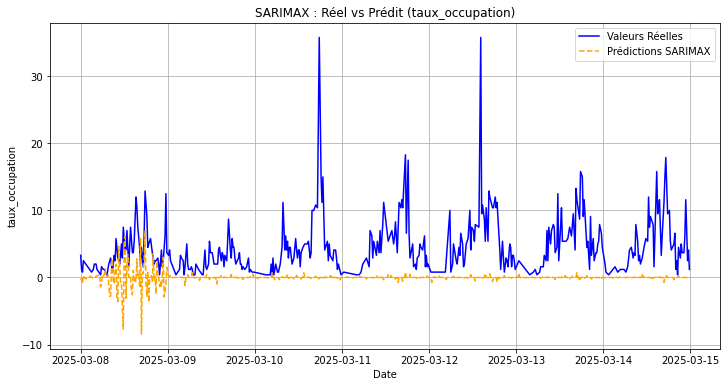

In [ ]:

# Remplissage des valeurs manquantes par la médiane (train) — appliquée à train et test
for col in all_regressors:
    median_val_train = train_regressors_all[col].median()
    train_regressors_all[col] = train_regressors_all[col].fillna(median_val_train)
    test_regressors_all[col] = test_regressors_all[col].fillna(median_val_train)

# Gestion des valeurs manquantes dans la cible
if train_target.isnull().any():
    print(f"Attention: Valeurs manquantes dans la cible d'entraînement '{target_variable}'.")
    train_target = train_target.fillna(train_target.median())

# --- Sélection des meilleurs régressors ---
correlations = train_regressors_all.corrwith(train_target).abs().sort_values(ascending=False)
top_features = correlations.head(top_k).index

train_regressors = train_regressors_all[top_features]
test_regressors = test_regressors_all[top_features]

# --- 2. Auto_ARIMA allégé (pour info uniquement, pas utilisé ensuite) ---
try:
    auto_model = pm.auto_arima(
        train_target,
        exogenous=train_regressors,
        start_p=1, start_q=1,
        max_p=2, max_q=2,     # Réduction de la complexité
        max_order=5,
        test='adf',
        m=96,  # Adapter si tu rééchantillonnes
        seasonal=True,
        start_P=0, max_P=1,
        start_Q=0, max_Q=1,
        D=None,
        stepwise=True,
        trace=True,
        error_action='ignore',
        suppress_warnings=True
    )
    print(auto_model.summary())
except ImportError:
    print("pmdarima n'est pas installé.")

# --- 3. Définition manuelle des ordres (plus rapide et léger) ---
sarimax_order = (1, 1, 1)
sarimax_seasonal_order = (0, 1, 1, 96)  # Adapter le 96 si tu changes la fréquence

print(f"Utilisation de l'ordre SARIMAX : {sarimax_order} et saisonnier : {sarimax_seasonal_order}")

# --- 4. Entraînement SARIMAX avec simple_differencing ---
try:
    model_sarimax = sm.tsa.SARIMAX(
        train_target,
        exog=train_regressors,
        order=sarimax_order,
        seasonal_order=sarimax_seasonal_order,
        simple_differencing=True,  # Allègement mémoire et vitesse
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    results_sarimax = model_sarimax.fit(disp=False)
    print(results_sarimax.summary())
except Exception as e:
    print(f"Erreur lors de l'entraînement du modèle SARIMAX : {e}")
    exit()

# --- 5. Prédiction ---
try:
    if len(test_regressors) != len(test_target):
        print(f"Attention: test_regressors ({len(test_regressors)}) et test_target ({len(test_target)}) n'ont pas la même longueur.")

    predictions_sarimax = results_sarimax.predict(
        start=test_target.index[0],
        end=test_target.index[-1],
        exog=test_regressors
    )
except Exception as e:
    print(f"Erreur lors de la prédiction SARIMAX : {e}")
    print(test_regressors.info())
    print(test_regressors.isnull().sum())
    exit()

# --- 6. Évaluation ---
if len(predictions_sarimax) == len(test_target):
    mae_sarimax = mean_absolute_error(test_target, predictions_sarimax)
    print(f"\n--- Évaluation SARIMAX ---")
    print(f"MAE : {mae_sarimax:.2f}")

    # --- 7. Visualisation ---
    plt.figure(figsize=(12, 6))
    plt.plot(test_target.index, test_target, label='Valeurs Réelles', color='blue')
    plt.plot(test_target.index, predictions_sarimax, label='Prédictions SARIMAX', color='orange', linestyle='--')
    plt.title(f"SARIMAX : Réel vs Prédit ({target_variable})")
    plt.xlabel("Date")
    plt.ylabel(target_variable)
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Erreur : le nombre de prédictions ne correspond pas au test set.")


## Amelioration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# --- 1. Nettoyage des données ---
for col in all_regressors:
    median_val_train = train_regressors_all[col].median()
    train_regressors_all[col] = train_regressors_all[col].fillna(median_val_train)
    test_regressors_all[col] = test_regressors_all[col].fillna(median_val_train)

# Supprimer les colonnes constantes (inutile pour le modèle)
constant_cols = [col for col in train_regressors_all.columns if train_regressors_all[col].nunique() <= 1]
train_regressors_all.drop(columns=constant_cols, inplace=True)
test_regressors_all.drop(columns=constant_cols, inplace=True)

# --- 2. Gestion de la cible ---
if train_target.isnull().any():
    print(f"Attention: Valeurs manquantes dans la cible '{target_variable}'")
    train_target = train_target.fillna(train_target.median())

# --- 3. Sélection des meilleurs régressors ---
correlations = train_regressors_all.corrwith(train_target).abs().sort_values(ascending=False)
top_features = correlations.head(top_k).index
train_regressors = train_regressors_all[top_features]
test_regressors = test_regressors_all[top_features]

# --- 4. Paramètres SARIMAX plus adaptés ---
sarimax_order = (2, 0, 2)
sarimax_seasonal_order = (1, 1, 1, 96)  # saisonnalité journalière si données à 15min

print(f"Utilisation de l'ordre SARIMAX : {sarimax_order} et saisonnier : {sarimax_seasonal_order}")

# --- 5. Entraînement SARIMAX ---
try:
    model_sarimax = SARIMAX(
        train_target,
        exog=train_regressors,
        order=sarimax_order,
        seasonal_order=sarimax_seasonal_order,
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    results_sarimax = model_sarimax.fit(disp=False)
    print(results_sarimax.summary())
except Exception as e:
    print(f"Erreur entraînement SARIMAX : {e}")
    exit()

# --- 6. Prédiction ---
try:
    if len(test_regressors) != len(test_target):
        print("Attention: Longueur incohérente entre test_target et test_regressors")

    predictions_sarimax = results_sarimax.predict(
        start=test_target.index[0],
        end=test_target.index[-1],
        exog=test_regressors
    )
except Exception as e:
    print(f"Erreur prédiction SARIMAX : {e}")
    exit()

# --- 7. Évaluation et Visualisation ---
if len(predictions_sarimax) == len(test_target):
    mae = mean_absolute_error(test_target, predictions_sarimax)
    print(f"\n--- Évaluation SARIMAX ---\nMAE : {mae:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(test_target.index, test_target, label='Valeurs Réelles', color='blue')
    plt.plot(test_target.index, predictions_sarimax, label='Prédictions SARIMAX', color='orange', linestyle='--')
    plt.title(f"SARIMAX : Réel vs Prédit ({target_variable})")
    plt.xlabel("Date")
    plt.ylabel(target_variable)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Erreur : tailles différentes entre prédictions et test_target.")


In [ ]:
# --- Vérification des longueurs ---
if len(predictions_sarimax) != len(test_target):
    print("Erreur : tailles différentes entre prédictions et test_target.")
else:
    # --- MAE ---
    mae = mean_absolute_error(test_target, predictions_sarimax)
    print(f"MAE (Mean Absolute Error) : {mae:.2f}")

    # --- Courbe : Réel vs Prédit ---
    plt.figure(figsize=(14, 6))
    plt.plot(test_target.index, test_target, label='Valeurs Réelles', color='blue')
    plt.plot(test_target.index, predictions_sarimax, label='Prédictions SARIMAX', color='orange', linestyle='--')
    plt.title(f"Comparaison Réel vs Prédit — SARIMAX ({target_variable})")
    plt.xlabel("Date")
    plt.ylabel(target_variable)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [12]:
# 1. Test ADF : Stationnarité
print("=== Test de stationnarité (ADF) sur la série cible ===")
result = adfuller(train_target.dropna())
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
if result[1] < 0.05:
    print("Série stationnaire (pas besoin de différenciation)")
else:
    print("Série NON stationnaire (différenciation probablement nécessaire)")

=== Test de stationnarité (ADF) sur la série cible ===
ADF Statistic: -8.8109
p-value: 0.0000
Série stationnaire (pas besoin de différenciation)



=== Corrélation des régressors avec la cible ===
temperature_2m            0.379682
wind_speed_10m            0.184934
visibility                0.041159
precipitation            -0.053128
is_vacances              -0.129029
is_ferie                       NaN
has_event_near_troncon         NaN
dtype: float64


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


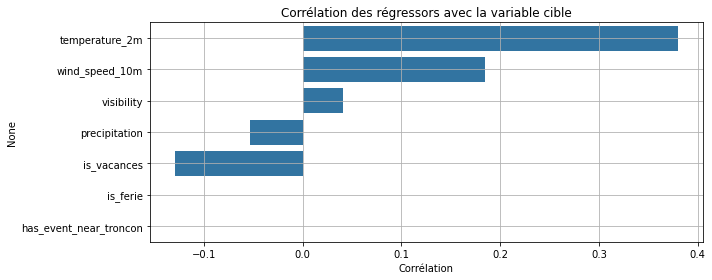

In [13]:
# 2. Corrélation des régressors avec la cible
print("\n=== Corrélation des régressors avec la cible ===")
correlations = train_regressors_all.corrwith(train_target).sort_values(ascending=False)
print(correlations)

plt.figure(figsize=(10, 4))
sns.barplot(x=correlations.values, y=correlations.index)
plt.title("Corrélation des régressors avec la variable cible")
plt.xlabel("Corrélation")
plt.grid(True)
plt.tight_layout()
plt.show()


=== Analyse de décalage (lag) pour un régressor clé ===
Meilleur décalage pour 'temperature_2m': 3 (corr = 0.3883)


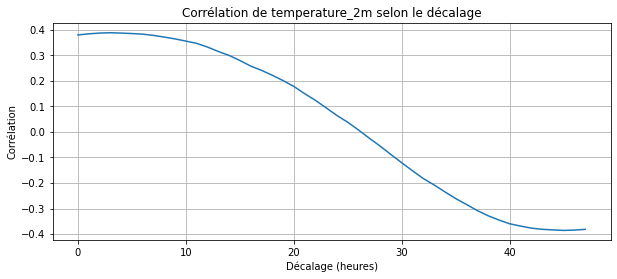

In [14]:
# 3. Analyse de décalage optimal (1er régressor uniquement à titre d'exemple)
print("\n=== Analyse de décalage (lag) pour un régressor clé ===")
top_regressor = correlations.index[0]
max_lag = 48
cor_lags = {
    lag: train_regressors_all[top_regressor].shift(lag).corr(train_target)
    for lag in range(max_lag)
}

best_lag = max(cor_lags, key=lambda x: abs(cor_lags[x]))
print(f"Meilleur décalage pour '{top_regressor}': {best_lag} (corr = {cor_lags[best_lag]:.4f})")

plt.figure(figsize=(10, 4))
plt.plot(list(cor_lags.keys()), list(cor_lags.values()))
plt.title(f"Corrélation de {top_regressor} selon le décalage")
plt.xlabel("Décalage (heures)")
plt.ylabel("Corrélation")
plt.grid(True)
plt.show()

In [15]:
# 4. (Optionnel) Relancer auto_arima avec plus de flexibilité
print("\n=== Lancement d'un auto_arima plus souple ===")
try:
    auto_model = pm.auto_arima(train_target,
                               exogenous=train_regressors_all[correlations.index[:top_k]],
                               start_p=1, start_q=1,
                               max_p=3, max_q=3,
                               d=None, D=None,
                               m=96,
                               seasonal=True,
                               stepwise=True,
                               trace=True,
                               suppress_warnings=True,
                               error_action='ignore')
    print(auto_model.summary())
except Exception as e:
    print("Erreur lors de l'exécution de auto_arima :", e)



=== Lancement d'un auto_arima plus souple ===
Performing stepwise search to minimize aic


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarni

 ARIMA(1,1,1)(1,0,1)[96] intercept   : AIC=inf, Time=106.95 sec
 ARIMA(0,1,0)(0,0,0)[96] intercept   : AIC=9498.336, Time=0.04 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[96] intercept   : AIC=9373.623, Time=18.30 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[96] intercept   : AIC=9304.126, Time=17.74 sec
 ARIMA(0,1,0)(0,0,0)[96]             : AIC=9496.337, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[96] intercept   : AIC=9315.751, Time=0.12 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[96] intercept   : AIC=inf, Time=54.26 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,2)[96] intercept   : AIC=9298.587, Time=105.90 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,2)[96] intercept   : AIC=inf, Time=332.38 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,2)[96] intercept   : AIC=9498.743, Time=86.93 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,2)[96] intercept   : AIC=9257.908, Time=158.53 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[96] intercept   : AIC=9264.824, Time=35.61 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,2)[96] intercept   : AIC=inf, Time=601.42 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[96] intercept   : AIC=9372.623, Time=92.63 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,2)[96] intercept   : AIC=9259.895, Time=229.34 sec


/Users/manu/opt/anaconda3/envs/Projet2/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


: 